## PROBLEM 1

In [1]:
#Import libraries:
import pyvista as pv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
from IPython import display

### Part A 

In [2]:
def read_units(units_path):
    '''
    This functions reads units.out file
    -------------------------------------------------------------------------
    PARAMETERS: 
    -units_path,file_path : the paths were the units and vtk files are
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns three arrays with the rho,vel,l normalisation data respectively
    -------------------------------------------------------------------------
    '''
    #Reading the units file
    units = pd.read_csv(units_path)
    
    #With .loc() we select the normalisation values for velocity,density and lenght.
    rho_0 = np.array(units.loc[units["variable"] == "rho_0"]["normalisation"])
    vel_0 = np.array(units.loc[units["variable"] == "v_0"]["normalisation"])
    l_0 = np.array(units.loc[units["variable"] == "L_0"]["normalisation"])
    
    #Normalization values of:
    
    #preassure
    prs_0 = rho_0*(vel_0)**2
    #magentic field 
    B_0 = np.sqrt(4*np.pi*rho_0*(vel_0)**2)
    #time
    time_0 = l_0/vel_0
    
    return rho_0,vel_0,l_0,prs_0,B_0,time_0

### Part B

In [3]:
def read_file(file_path,rho_0,vel_0,B_0,prs_0):
    '''
    This functions reads vtk##.out file
    -------------------------------------------------------------------------
    PARAMETERS: 
    -file_path : the paths were the vtk files is
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns three arrays with the rho,vel,l normalisation data respectively
    -------------------------------------------------------------------------
    '''
    
    # Opening the mesh
    mesh = pv.read(file_path)
    
    # Getting the data arrays
    rho = pv.get_array(mesh, "rho", preference = 'cell') #density in code units
    prs = pv.get_array(mesh, "prs", preference = 'cell') #prs in code units
    tr1 = pv.get_array(mesh, "tr1", preference = 'cell') #tr1 in code units    
    vx1 = pv.get_array(mesh, "vx1", preference = 'cell') #vx in code units
    vx2 = pv.get_array(mesh, "vx2", preference = 'cell') #vy in code units  
    bx1 = pv.get_array(mesh, "Bx1", preference = 'cell') #bx in code units
    bx2 = pv.get_array(mesh, "Bx2", preference = 'cell') #by in code units
    
    # Convert the arrays to 2D
    rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    prs_2D = prs.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    tr1_2D = tr1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    vx1_2D = vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    vx2_2D = vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    bx1_2D = bx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    bx2_2D = bx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
    
    
    # Convert arrays to CGS units
    rho_cgs2D = rho_2D*rho_0
    vx1_cgs2D = vx1_2D*vel_0
    vx2_cgs2D = vx2_2D*vel_0
    bx1_cgs2D = bx1_2D*B_0
    bx2_cgs2D = bx2_2D*B_0
    prs_cgs2D = prs_2D*prs_0
    

    return rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D

In [4]:
#defining the files path: 
file_path = ('/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0035.vtk')
units_path = ('/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/units.out')

#calling function of part a: 
rho_0,vel_0,l_0,prs_0,B_0,time_0 = read_units(units_path)

#Calling the function and storing the values: 
rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)

### Part C

In [5]:
def plot_array(title,array_cgs2D,map_color):
    '''
    This functions plots the given 2D normalized array
    -------------------------------------------------------------------------
    PARAMETERS: 
    -title: tittle of the map, 
    -array_cgs2D: the array to plot  
    -map_color: perceptually-uniform colour schemes
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns plot of the given array
    -------------------------------------------------------------------------
    '''
    #Plotting the given array:
    plt.figure(figsize = (5,3))
    Z = plt.pcolor(x_2d, y_2d, array_cgs2D,cmap = map_color)
    plt.title(title)
    plt.colorbar(Z)
    plt.show()

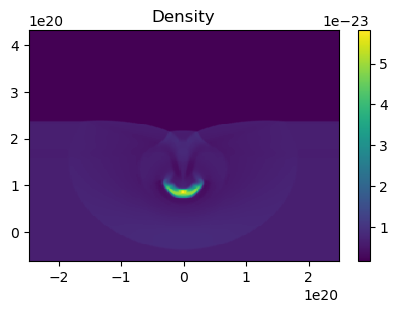

In [6]:
#Creating the mesh: 
mesh  =  pv.read(file_path)

#Create coordinate vectors:
x = np.linspace(mesh.bounds[0], mesh.bounds[1],mesh.dimensions[1] - 1)*l_0
y = np.linspace(mesh.bounds[2], mesh.bounds[3],mesh.dimensions[0] - 1)*l_0
    
#Creating the Grid
x_2d, y_2d = np.meshgrid(x, y)

#calculating the modulus for the plots of velocity and magnetic field: 
modulus_v = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)
modulus_b = np.sqrt(bx1_cgs2D**2 + bx2_cgs2D**2)

#ploting density:
plot_array("Density",rho_cgs2D,'viridis')

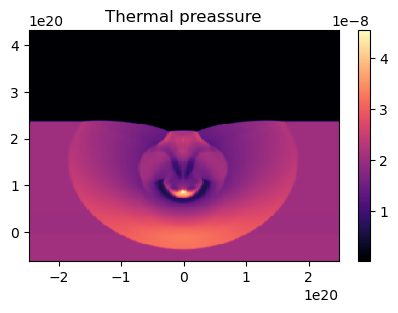

In [7]:
#ploting thermal preassure: 
plot_array("Thermal preassure",prs_cgs2D,'magma')

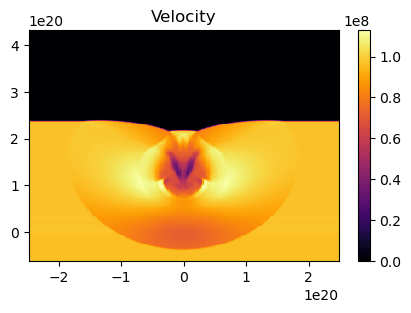

In [8]:
#ploting velocity: 
plot_array("Velocity",modulus_v,'inferno')

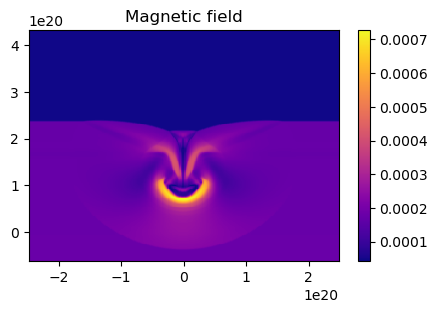

In [9]:
#ploting magnetic field:
plot_array("Magnetic field",modulus_b,'plasma')

## PROBLEM 2 

### Part A

In [10]:
def isolate(rho_cgs2D,tr1_2D):
    '''
    This functions isolates th shock cell for the density 2D normalized array
    -------------------------------------------------------------------------
    PARAMETERS: 
    -array_cgs2D:the array to isolate
    -tr1_2D: Pigment that trace the gas array
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns an array containing the candidates shock cells
    -------------------------------------------------------------------------
    '''
    #Reading over all the values in tr1:
    for i in range(len(tr1_2D)):
        for j in range (len(tr1_2D)):
            
            #Settign the condition:
            if tr1_2D[i][j] < 0.05:
                
                #Replacing value:
                rho_cgs2D[i][j] = np.nan
            
    return rho_cgs2D

### Part B

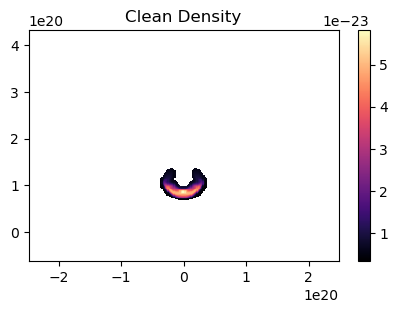

In [11]:
#savinf new values:
clean_rho2D = isolate(rho_cgs2D,tr1_2D)

#Ploting:
plot_array("Clean Density",clean_rho2D,'magma')

### Part C

In [12]:
#Defining a function for the first method: 
def method_1(vx1,vx2,dx): 
    '''
    This functions reproduce method1
    -------------------------------------------------------------------------
    PARAMETERS: 
    -components of velocity and dx 
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns new array using method1 
    -------------------------------------------------------------------------
    '''
    #getting the gradient for each component
    x_comp = np.gradient(vx1, dx, axis = 1)
    y_comp = np.gradient(vx2, dx, axis = 0)
    
    #divergnece of velocity
    divergence = x_comp + y_comp 
    
    new_div = np.where(divergence < 0.0, divergence, np.nan)
    
    return new_div

#Defining a function for the second method: 
def method_2 (preassure_2D,dx): 
    '''
    This functions reproduce method2
    -------------------------------------------------------------------------
    PARAMETERS: 
    -components of preassure and dx 
    -------------------------------------------------------------------------
    OUTPUT:
    -Returns new array using method2 
    -------------------------------------------------------------------------
    '''
    #getting the gradient of prs
    gradient_prs = np.gradient(prs_cgs2D, dx)
    
    #the x and y componets:
    x_component = gradient_prs[0]
    y_component = gradient_prs[1]
    
    #Modulus of the preassure divergence
    modulus_prs = np.sqrt(x_component**2 + y_component**2)
    
    #absolute values of the divergence
    absolute_val = np.abs(modulus_prs)
    
    #calculating the ratio between abs(divergence)/prs:
    ratio = absolute_val/prs_cgs2D
    
    #replacing values
    new_prs = np.where(ratio > 0.01*np.max(ratio), modulus_prs, np.nan)
    
    return new_prs

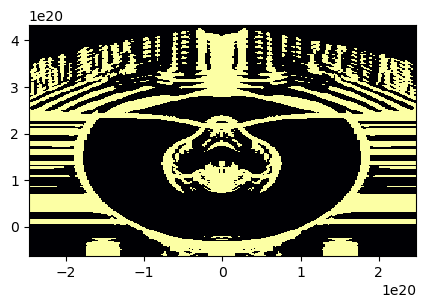

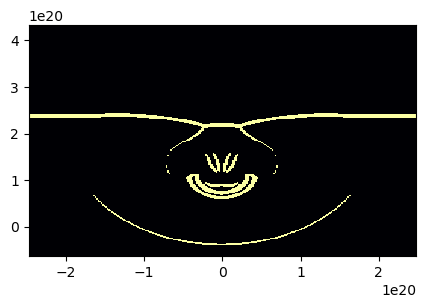

In [13]:
#defining dx for the gradient:
dx = float(x[1] - x[0])

#calling the metohd's functions
Method_1 = method_1(vx1_cgs2D,vx2_cgs2D,dx)
Method_2 = method_2(prs_cgs2D,dx)

#converting to binary array:
Method_1 = np.where(Method_1[:][:] < 0, 1 ,0)
Method_2 = np.where(Method_2[:][:] > 0, 1 ,0)

#ploting method 1:
plt.figure(figsize = (5,3))
plt.pcolor(x_2d, y_2d, Method_1, cmap = "inferno")
plt.show()

#ploting method 2: 
plt.figure(figsize = (5,3))
plt.pcolor(x_2d, y_2d, Method_2, cmap = "inferno")
plt.show()

## PROBLEM 3

### Part A 

In [14]:
#Defining a function to normalize time: 
def time_norm(vtk_path,time_0):
    '''
    This functions read the time and nomralize it 
    -------------------------------------------------------------------------
    PARAMETERS: 
    - file_name: path of the file
    -------------------------------------------------------------------------
    OUTPUT:
    -normalised time array 
    -------------------------------------------------------------------------
    '''
    #Reading the data
    time_data = pd.read_csv(vtk_path,sep='\s+',header=None)
    
    #time array: 
    time = time_data.iloc[:,1]
        
    #normalising time: 
    time_norm = time*time_0
    
    return time_norm

In [15]:
#vtk file path
vtk_path =('/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/vtk.out')

#calling the function:
time = time_norm(vtk_path,time_0)

### Part B 

In [16]:
#Create the direcotry to save the plots: 
os.makedirs("/home/jdiego/Documents/Computacional_1/maps")
os.makedirs("/home/jdiego/Documents/Computacional_1/features")

In [17]:
#modifiying the plot_array function to save the plot instead of showing it: 
def save_array(title,array_cgs2D,map_color,path):
    '''
    This functions will save the plot of the given 2D normalized array
    -------------------------------------------------------------------------
    PARAMETERS: 
    -title: tittle of the plot, 
    -array_cgs2D:the array to plot and the 
    -map_color:perceptually-uniform colour schemes
    -path: were to save the plot
    -------------------------------------------------------------------------
    OUTPUT:
    -Saves the plot of the given array
    -------------------------------------------------------------------------
    '''
    #Plotting the given array:
    plt.figure(figsize = (5,3))
    Z = plt.pcolor(x_2d, y_2d, array_cgs2D,cmap = map_color)
    plt.title(title)
    plt.colorbar(Z)
    plt.savefig(path + "/"+ title +".0{:03d}.jpg".format(i))
    plt.close()

In [18]:
#were to save the plots: 
path = "/home/jdiego/Documents/Computacional_1/maps"

#for the plots to be in order I made 4 for loops to each of the different plots:
for i in range(0,len(time)):
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #ploting density:
    save_array("Density",rho_cgs2D,'viridis',path)

In [19]:
for i in range(0,len(time)):    
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #ploting density:
    save_array("Thermal preassure",prs_cgs2D,'magma',path)

In [20]:
for i in range(0,len(time)):
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #calculating the modulus for the plots of velocity: 
    modulus_v = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)
    
    #ploting velocity: 
    save_array("Velocity",modulus_v,'inferno',path)

In [21]:
for i in range(0,len(time)):
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #calculating the modulus for the plot of magnetic field:
    modulus_b = np.sqrt(bx1_cgs2D**2 + bx2_cgs2D**2)
    
    #ploting magnetic field:
    save_array("Magnetic field",modulus_b,'plasma',path)

In [22]:
#were to save the plots:
path2 = "/home/jdiego/Documents/Computacional_1/features"

#now plot the candidate shock cells: 
for i in range(len(time)):
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #caling the metohd's functions
    Method_1 = method_1(vx1_cgs2D,vx2_cgs2D,dx)
    Method_2 = method_2(prs_cgs2D,dx)
    
    #converting to binary array:
    Method_1 = np.where(Method_1[:][:] < 0, 1 ,0)
    Method_2 = np.where(Method_2[:][:] > 0, 1 ,0)
    
    #ploting and saving method 1:
    plt.figure(figsize = (5,3))
    plt.pcolor(x_2d, y_2d, Method_1, cmap = "inferno")
    plt.savefig(path2 + "/Method_1" +".0{:03d}.jpg".format(i))
    plt.close()

    #ploting and saving method 2: 
    plt.figure(figsize = (5,3))
    plt.pcolor(x_2d, y_2d, Method_2, cmap = "inferno")
    plt.savefig(path2 + "/Method_2"+".0{:03d}.jpg".format(i))
    plt.close()

### Part C

In [23]:
#Creating the movie function: 
def movie(images_input,name):
    '''
    This functions creates a movie with the images from a given directory
    ----------------------------------------------------------------------
    Parameters: 
    -imeges_input, name(name to save the giff)
    -----------------------------------------------------------------------
    RETURNS: a giff of the images
    ------------------------------------------------------------------------
    '''
    #path to save the gift:
    path =  "/home/jdiego/Documents/Computacional_1/maps/"+name+".pillow.gif"
    
    #Collect the images
    imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

    img = next(imgs)

    img.save(fp = path, format="GIF", append_images=imgs,\
        save_all=True, duration = 100, loop = 0)

In [24]:
#Creating and saving the movie 
input1 = "/home/jdiego/Documents/Computacional_1/maps/Magnetic field.***.jpg"
name1 = "Magnetic field"
movie(input1,name1)

## PROBLEM 4

### Part A

In [25]:
def total_mass(rho_2D,dxx,tr1_2D): 
    '''
    This functions calculates the total mass of the cloud
    ----------------------------------------------------------------------
    Parameters: 
    -density,pgiment and dx
    -----------------------------------------------------------------------
    RETURNS: total mass 
    ------------------------------------------------------------------------
    '''
    
    #using tr1_2D to trace:
    tot = rho_2D*tr1_2D
    #calculating the mass:
    total_mass = (dxx**3)*np.sum(np.sum(tot,axis =1), axis = 0)
    
    return total_mass


def center_of_mass(rho2D,tr12D,x,y):
    '''
    This functions calculates the center of mass of the cloud
    ----------------------------------------------------------------------
    Parameters: 
    -density and pigmet
    -----------------------------------------------------------------------
    RETURNS: center of mass
    ------------------------------------------------------------------------
    '''
    
    x_mid = 0.5*(x[1:] + x[:-1])
    y_mid = 0.5*(y[1:] + y[:-1])
    
    cx_2D = np.sum(np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1],axis=0)*(x_mid))/np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1])
    cy_2D = np.sum(np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1],axis=1)*(y_mid))/np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1])
    
    return (cx_2D,cy_2D)

def mass1(rho2D,tr12D):
    '''
    This functions mass of the cloud
    ----------------------------------------------------------------------
    Parameters: 
    -density and pigment
    -----------------------------------------------------------------------
    RETURNS: coordinates
    ------------------------------------------------------------------------
    '''
    cx_2D = np.sum(np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1],axis=0))/np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1])
    cy_2D = np.sum(np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1],axis=1))/np.sum(rho2D[:-1,:-1]*tr12D[:-1,:-1])
    
    return (cx_2D,cy_2D)

def derivative(array,time):
    '''
    This functions calculates derivatives
    ----------------------------------------------------------------------
    Parameters: 
    -array to derive
    -----------------------------------------------------------------------
    RETURNS: derivatives
    ------------------------------------------------------------------------
    '''
    #Computing the derivative: 
    deriv = np.diff(array) / np.diff(time)
    
    return deriv

In [26]:
total= []
center = [] 
massl = []
for i in range(0,len(time)):
    
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Creating the mesh: 
    mesh  =  pv.read(file_path)

    #Create coordinate vectors:
    x = np.linspace(mesh.bounds[0], mesh.bounds[1],mesh.dimensions[1] - 1)*l_0
    y = np.linspace(mesh.bounds[2], mesh.bounds[3],mesh.dimensions[0] - 1)*l_0
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #calculating the modulus for the plot of magnetic field:
    modulus_b = np.sqrt(bx1_cgs2D**2 + bx2_cgs2D**2) 
    
    #since dx=dy=dz we just compute dx:
    dx = x[1] - x[0]

    #total mass
    mass = total_mass(rho_cgs2D,dx,tr1_2D)
    
    #Saving the values 
    total.append(mass)
    
    cen = center_of_mass(rho_cgs2D,tr1_2D,x,y)
    
    center.append(cen)
    
    m = mass1(rho_cgs2D,tr1_2D)
    
    massl.append(m)
    
#convertign into array: 
total = np.array(total)

#converting center of mass
center = np.array(center)

#mass of cloud:
massl = np.array(massl)

#Computing the derivative of total mass: 
deriv = derivative(total,time)

#Computing the velocity: 
deriv2 = derivative(massl,time)

#COmputing acelration: 
deriv3 = derivative(deriv2,time[:-1])

#To calculate the middle times recursively:
time2 = (time[:-1] + time[1:]) / 2 


### Part B

In [27]:
def ploting(array,time):
    '''
    This functions plots the given arrays
    ----------------------------------------------------------------------
    Parameters: 
    -array and time array 
    -----------------------------------------------------------------------
    RETURNS: plot of arrays 
    ------------------------------------------------------------------------
    '''
    #ploting: 
    plt.figure(figsize = (5,3))
    plt.plot(time,array)
    plt.show()

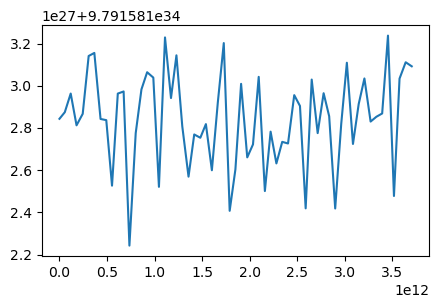

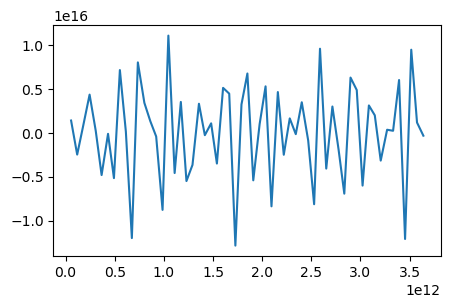

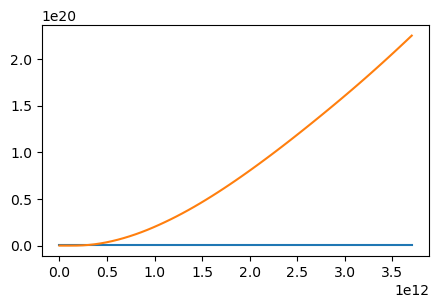

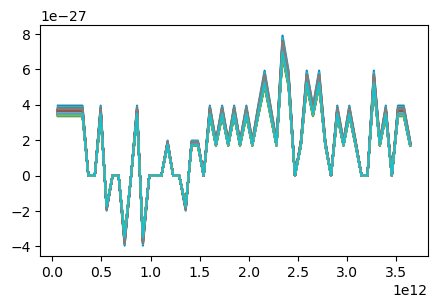

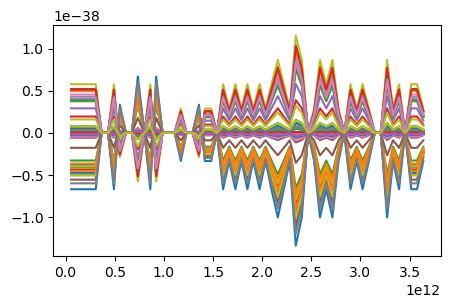

In [28]:
#Ploting total mass:
ploting(total,time)

#derivative of total mass:
ploting(deriv,time2[:-1])

#center of mass:
ploting(center,time)

#velocity:
ploting(deriv2,time2)

#acceleration:
ploting(deriv3,time2)

### Part C

In [29]:
#were to save the plots: 
path = "/home/jdiego/Documents/Computacional_1/maps"

#loping over the files: 
for i in range(len(time)):
    #Path of the file
    file_path = "/home/jdiego/Documents/Computacional_1/MHD-shock-cloud/MHD-shock-cloud/data.0{:03d}.vtk".format(i)
    
    #Function of part B
    rho_cgs2D, vx1_cgs2D ,vx2_cgs2D,bx1_cgs2D ,bx2_cgs2D ,prs_cgs2D,tr1_2D = read_file(file_path,rho_0,vel_0,B_0,prs_0)
    
    #saving new values:
    clean_rho2D = isolate(rho_cgs2D,tr1_2D)
    
    #saving
    save_array("Center of mass",clean_rho2D,'viridis',path)
    

In [30]:
#Creating and saving the movie of center of mass and density:
input2 = "/home/jdiego/Documents/Computacional_1/maps/Center of mass.***.jpg"
name2 = "Evolution of center of mass"
movie(input2,name2)

input3 = "/home/jdiego/Documents/Computacional_1/maps/Density.***.jpg"
name3 = "Evolution of Density"
movie(input3,name3)